# Phase 2 - Machine Learning with XGBoost

- More information - Phase 0 (Business Requirement) and Phase 1 (EDA using Python)

<div class="alert alert-block alert-info">
<b>Info:</b> This notebook will be implemented using Python and will provide the same information
    of R notebook (xgb with R)
    <br> Same charts and information but using Python instead of R
</div>


#### Exploratory Data Analysis (EDA) - customer support and 

#### Deep investigation to identify why and which characteristics led the customers to churn

#### Dataset
The dataset used in this process can be accessed through IBM website below

https://www.ibm.com/communities/analytics/watson-analytics-blog/guide-to-sample-datasets/


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import utilsEDA
## from sklearn.preprocessing import Imputer

import warnings
warnings.filterwarnings("ignore")

## Export model
import pickle

In [2]:
df1 = pd.read_csv('../data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df1.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


#### Info
- One dataset related to a telco customer can have hundreds, sometimes thousand of features to analyse
- To keep the process simple it is going to be used the top 5 features from Phase 1 + gender to add some context of analysis
- Obs. the categorical features ('gender', 'PaymentMethod' , 'Contract') will be analyzed by each detailed information <br> (One Hot Encode techinque) present later in this notebook

In [3]:
## Filter columns and set values
df1.loc[(df1.tenure==0) & (df1.TotalCharges == ' '), ['TotalCharges', 'tenure']] = 0
df1['TotalCharges'] = df1['TotalCharges'].astype('float')

target = 'Churn'
current_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'gender', 'PaymentMethod' , 'Churn', 'Contract']

df1 = df1[current_features]
df1.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
tenure,7043,NaN,NaN,NaN,32.3711,24.5595,0,9,29,55,72
MonthlyCharges,7043,NaN,NaN,NaN,64.7617,30.09,18.25,35.5,70.35,89.85,118.75
TotalCharges,7043,NaN,NaN,NaN,2279.73,2266.79,0,398.55,1394.55,3786.6,8684.8
gender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PaymentMethod,7043,4,Electronic check,2365,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Churn,7043,2,No,5174,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Contract,7043,3,Month-to-month,3875,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Analyse charges and churn by gender

#### Info
- The Monthly Charge, Total Charges and churn(yes/no) is well distributed between gender as showed by graphic below

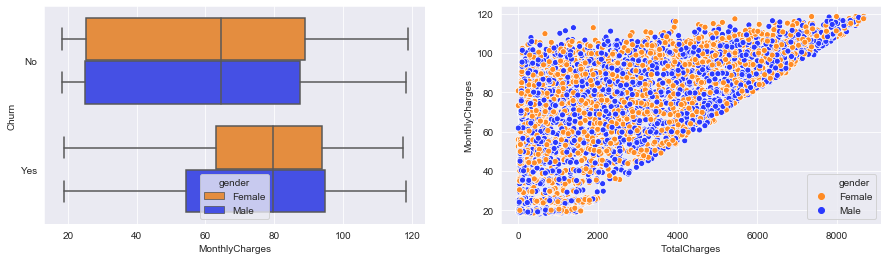

In [4]:
## Plot charges by gender
sns.set_style(style='darkgrid')
colors = ['#ff8b24', '#2a39ff']
customPalette = sns.set_palette(sns.color_palette(colors))
fig, axs = plt.subplots(ncols=2, figsize=(15,4))
sns.boxplot(x='MonthlyCharges',  y='Churn', hue='gender' , data=df1, ax=axs[0], palette=customPalette)
sns.scatterplot(x='TotalCharges', y='MonthlyCharges', hue='gender', data=df1, ax=axs[1], palette=customPalette)

## Analyse the Payment Method and charges associated with Churn (Yes or No)

#### Note
- The Payment Method (Eletronick check: biggest one) have quite the same proportion of Churn (Yes or No)
    seems to not influence a lot. 
- Other types of payments can influence the customer churn but have less customers associated with it
    

## 1st Insight
- The first important insight is the confirmation of a lot of Churners caused by Monthly Charges without correlation high Total Charges
- Note that high Total Charges do not have so many churners also

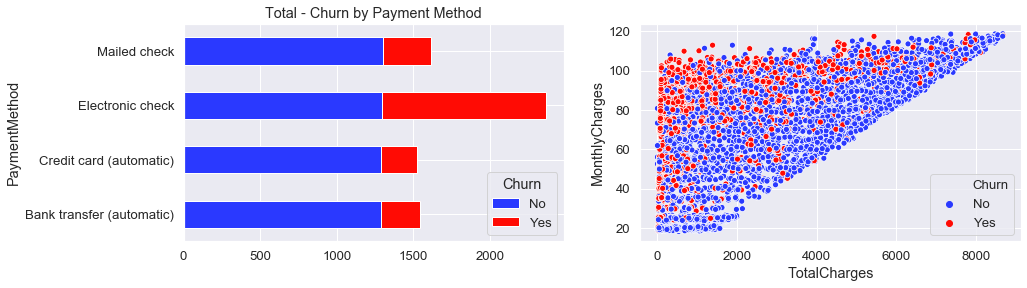

In [5]:
df_group = df1.groupby(by=['PaymentMethod', 'Churn'])['tenure'].count().reset_index().copy()
df_group.columns = ['PaymentMethod', 'Churn', 'Qt']
df_group = df_group.sort_index(by='Qt', ascending=False)
pivot_df = df_group.pivot(index='PaymentMethod', columns='Churn', values='Qt')

sns.set(font_scale=1.2) ## Higher font scale
# ## Plot Churn 
colors = ['#2a39ff', "#FF0B04"]
customPalette = sns.set_palette(sns.color_palette(colors))
fig, axs = plt.subplots(ncols=2, figsize=(15,4))
g1 = pivot_df.plot.barh(stacked=True, color=colors, ax=axs[0], title='Total - Churn by Payment Method')
# g1.plt.xlabel('customers_n')
sns.scatterplot(x='TotalCharges', y='MonthlyCharges', hue='Churn', data=df1, ax=axs[1], palette=customPalette)

## Investigate monthly charges by contract type, by tenure and churners

#### Note
- The customer churners are not well distributed between contract types
- Long term contracts such as Two years and also One Year have much less churners
    

## 2nd Insight
- The higher volume of churners are associated with Month-to-Month Contract with high Monthly Charges and usually small tenure

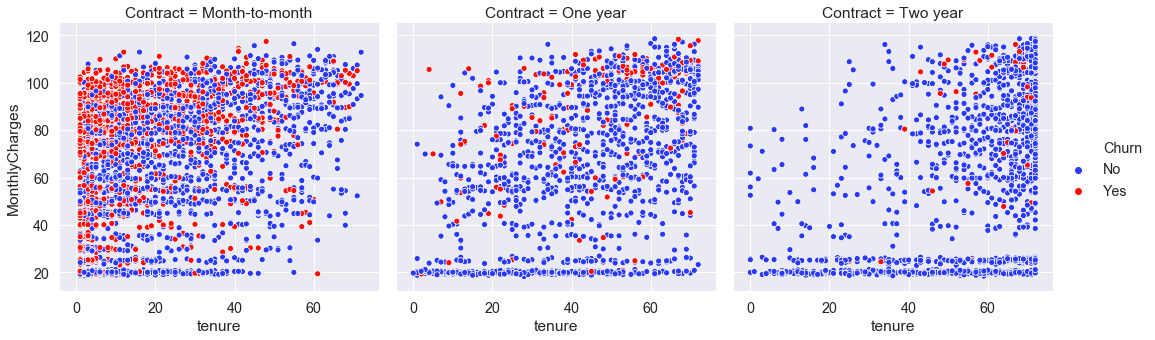

In [6]:
sns.set(font_scale=1.3) ## Higher font scale
colors = ['#2a39ff', "#FF0B04"]
customPalette = sns.set_palette(sns.color_palette(colors))
sns.relplot(x='tenure', y='MonthlyCharges', col='Contract', hue='Churn', kind='scatter', data=df1, palette=customPalette)

### Let´s run one machine learning algorithm to identify the relationship in the data

- Run xgboost model and plot the feature importance 
- - the idea here is also to improve the model accuracy achieved with Random Forest in Phase 1
    
    
- One trick: use of One Hot Encoding and not the Label Encoding used Phase 1
- - the target with this trick is to see the detailed features that drives customers to churn
- - and also to confirm if the analysis above can be sustained by the machine learning model

## Execution of the machine learning model (xgb)

- Website info: https://xgboost.readthedocs.io/en/latest/python/python_intro.html

- Build xgb model with XGBoost core (with parameters example) and sklearn wrapper for XGBoost and compare the results from models

### Obs. The xgb execution below will be done in 2 ways
- xgb core
- xbg sklearn wrapper

## XGB Core execution

In [7]:
## ML : XGBOOST

import xgboost as xgb
import numpy as np

## Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

## Metrics - Classification
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

## Report dataframe
df_RPT = df1.copy()

## OHE categorical features
df1 = pd.get_dummies(df1, columns=['gender', 'PaymentMethod' , 'Contract'])
# print(df1.head(3))

target = 'Churn'
features = df1.columns.to_list()
features.remove(target)

le = LabelEncoder()
X = df1[features].values
y = le.fit_transform(df1['Churn'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

## xgb Parameters - default
parameter_xbg = {'max_depth': 10, 'eta': 1, 'objective': 'binary:logistic', 'eval_metric': 'auc'}
evallist = [(dtest, 'eval'), (dtrain, 'train')]

num_round = 10
fit_xgb = xgb.train(parameter_xbg, dtrain, num_boost_round=num_round, evals=evallist)
# print(fit_xgb)

## Prediction
ypred = fit_xgb.predict(dtest)
ypred = np.round(ypred)
print('')
print(' Precict sample')
print(ypred[:10])

## XGBOOST - core
print('')
print('Model type: ' , type(fit_xgb) )

[0]	eval-auc:0.811839	train-auc:0.893568
[1]	eval-auc:0.812782	train-auc:0.920016
[2]	eval-auc:0.813683	train-auc:0.928964
[3]	eval-auc:0.809304	train-auc:0.93903
[4]	eval-auc:0.809967	train-auc:0.945341
[5]	eval-auc:0.81135	train-auc:0.950655
[6]	eval-auc:0.81235	train-auc:0.956579
[7]	eval-auc:0.81105	train-auc:0.964021
[8]	eval-auc:0.811615	train-auc:0.971746
[9]	eval-auc:0.811901	train-auc:0.977281

 Precict sample
[1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]

Model type:  <class 'xgboost.core.Booster'>


## Build XGBoost model with Scikit-Learn API - XGBClassifier

site: https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

In [8]:
## XGBOOST - Scikit-Learn API
from xgboost import XGBClassifier
model_xgb = XGBClassifier()

model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [9]:
## XGBOOST - Model type and prediction
print('')
print('Model type: ' , type(model_xgb) )

ypred_xgb_sklearn = model_xgb.predict(X_test)
print('')
print(' Precict sample')
print(ypred_xgb_sklearn[:10])


Model type:  <class 'xgboost.sklearn.XGBClassifier'>

 Precict sample
[1 0 0 1 0 0 0 0 0 0]


### Evaluation with confusion matrix
- Evaluate model performance
- Compare results between xgb core vs. xgb sklearn wrapper

#### Info: the accuracy divergence between these 2 xgb models (77,6% vs. 79,9%) are associated with default parameters and other info
- The main idea here is to show how to run xgb in these 2 ways

In [10]:
def print_confusion_matrix(y_true, y_pred):
    """Function to print Confusion Matrix and metrics"""

    report = classification_report(y_true, y_pred)
    confusion_matrix_rpt = confusion_matrix(y_true, y_pred)
    accuracy_score_rpt = accuracy_score(y_true, y_pred)
    
    print('--   Confusion Matrix')
    print('0   FP')
    print('FN  1')
    print('')
    print(confusion_matrix_rpt)
    print('')
    print('--   Accuracy')
    print(accuracy_score_rpt)
    print('')
    print('--   Metrics report')
    print(report)

print('')
print('----  XGBOOST CORE execution')    
print('')
print_confusion_matrix(y_test, ypred)

print('')
print('----  XGBOOST sklearn wrapper')    
print('')
print_confusion_matrix(y_test, ypred_xgb_sklearn)



----  XGBOOST CORE execution

--   Confusion Matrix
0   FP
FN  1

[[1482  215]
 [ 306  322]]

--   Accuracy
0.7759139784946236

--   Metrics report
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1697
           1       0.60      0.51      0.55       628

    accuracy                           0.78      2325
   macro avg       0.71      0.69      0.70      2325
weighted avg       0.77      0.78      0.77      2325


----  XGBOOST sklearn wrapper

--   Confusion Matrix
0   FP
FN  1

[[1550  147]
 [ 320  308]]

--   Accuracy
0.7991397849462366

--   Metrics report
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1697
           1       0.68      0.49      0.57       628

    accuracy                           0.80      2325
   macro avg       0.75      0.70      0.72      2325
weighted avg       0.79      0.80      0.79      2325



### Best XGBoost model achieved 79,9% of accuracy score - XGBClassifier
#### Improvement of 3% of accuracy compared to random forest in phase 1

- The accuracy now is 79,9% instead of 77% (Phase 1 with Random Forest)

## Export the model

#### Save / store the xgb model for prediction

- Info: The results with xgboost.sklearn.XGBClassifier was better than xgb.core
- Save best score model and run one new prediction to guarantee everything is fine

In [11]:
## Export with pickle
file_export_model = './ML_models/model_xgb_baseline_v1.sav'
pickle.dump(model_xgb, open(file_export_model, 'wb'))
print('Export done!')

Export done!


### Reload and test if exported model is fine

In [12]:
## Load the exported model
xgb_load_model = pickle.load(open(file_export_model, 'rb'))

## Test with new predictions
ypred_new = xgb_load_model.predict(X_test)
print('-- New prediction sample')
print(ypred_new[:10])

print('')
print('Load and prediction done!')

-- New prediction sample
[1 0 0 1 0 0 0 0 0 0]

Load and prediction done!


## Plot - Feature importance
- xgb core

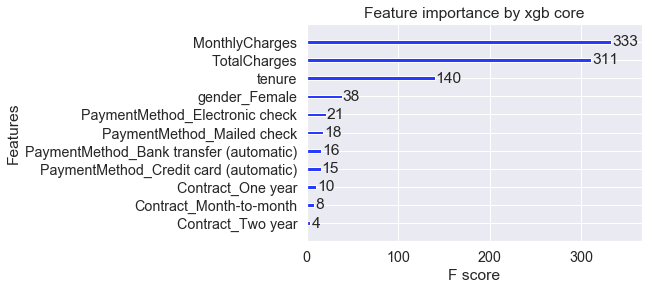

In [13]:
## Feature importance
fit_xgb.feature_names = features
xgb.plot_importance(fit_xgb)
plt.title('Feature importance by xgb core')
plt.show()

## Plot - Feature importance
- xgb sklearn wrapper

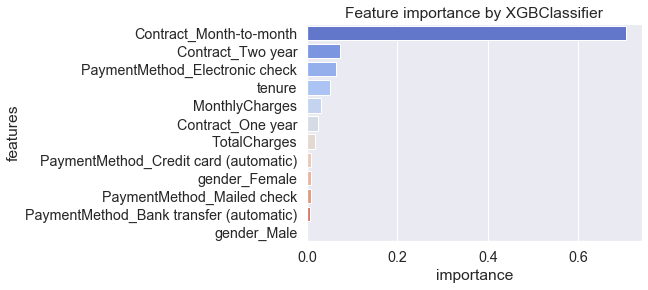

In [14]:
# Plot feature importance
feature_importances = pd.DataFrame({'features': features, 
                            'importance': model_xgb.feature_importances_}).sort_values('importance', ascending=False)

ax = sns.barplot(x="importance", y="features", 
                 data=feature_importances, palette="coolwarm").set_title('Feature importance by XGBClassifier')


## 3rd Insight
- Contract type and Month to Month contract are the most important features
### Evaluate the distribution of churners by contract type

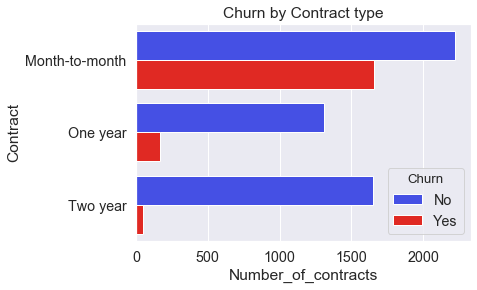

In [15]:
## Plot
df_plot = df_RPT.groupby(['Contract','Churn'])['tenure'].count().reset_index()
df_plot.columns = ['Contract', 'Churn', 'Number_of_contracts']
# sns.barplot(x='Number_of_contracts', y='Contract', hue='Churn', data=df_plot).set_title('Churn by Contract type')
sns.barplot(x='Number_of_contracts', y='Contract', hue='Churn', data=df_plot)
plt.title('Churn by Contract type')
plt.show()

## How much revenue will be lost by contract type? 

- May be the charges are quite similar between contract type and tenure ... let's see...

#### Revenue stopped because the customer churn

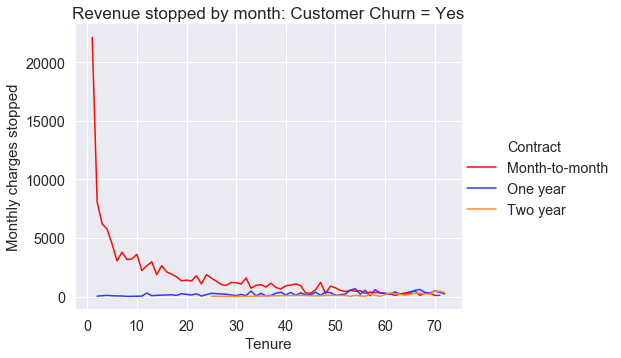

In [16]:
# df %>% filter(Churn=='Yes') %>%   
#   group_by(tenure, Contract) %>% 
#   summarise( MonthlyCharges=sum(MonthlyCharges), 
#              TotalCharges=sum(TotalCharges))  %>% 
#   qplot(data=. ,x=tenure, y=MonthlyCharges, 
#         geom='area', alpha=0.5, fill=Contract,
#         main='    Revenue stopped: Customer Churn = Yes')

# ['#ff8b24', '#2a39ff']
colors = ["#FF0B04", '#2a39ff', '#ff8b24']
customPalette = sns.set_palette(sns.color_palette(colors))

rpt_plot = (df_RPT.loc[df_RPT.Churn == 'Yes']
            .groupby(['tenure', 'Contract'])[['MonthlyCharges', 'TotalCharges']]
            .sum()
            .reset_index()
            .sort_values(by=['MonthlyCharges', 'tenure'], ascending=False)
           )

## Plot line chart
sns.relplot(data=rpt_plot, 
            x='tenure', 
            y='MonthlyCharges', 
            hue='Contract', kind='line',
            height=5, aspect=1.4,linestyle='solid',
            palette=customPalette
           )

plt.xlabel('Tenure', fontsize=15)
plt.ylabel('Monthly charges stopped', fontsize=15)
plt.title('Revenue stopped by month: Customer Churn = Yes',fontsize=17)

plt.show()

# Summary

- Following the charts below and also the execution of xgb with R we have:

### The top 3 most important features related to churn (Yes) are:

- Higher Monthly Charges
- Small to Medium Tenure and associated with
- Month-to-Month contract

##### Well done... better clear picture of why customers churn

- Let´s move on with more analysis and model build with next notebooks

In [19]:
# !jupyter nbconvert --to html Phase_2_Build_ML_models_with_Python_1x6_xgboost.ipynb